# Imports

In [1]:
import pandas as pd
import numpy as np
import string
import re
import mpmath
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px
import plotly.graph_objects as go
import plotly.colors

## Reading in the initial .csv files provided

In [2]:
#reading the two datasets
police_press_releases = pd.read_csv('police_press_releases.csv')
local_news_articles = pd.read_csv('local_news_articles.csv')

In [3]:
vertical_title = pd.concat([police_press_releases['title'], local_news_articles['title']], axis=0)
vertical_date = pd.concat([police_press_releases['date_published'], local_news_articles['publish_date']], axis=0)
vertical_content_details = pd.concat([police_press_releases['content'], local_news_articles['content']], axis=0)
df_vertical_title = pd.DataFrame({'title':vertical_title})
df_vertical_date = pd.DataFrame({'date':vertical_date})
df_vertical_content_details = pd.DataFrame({'content':vertical_content_details})

In [4]:
data = {'date': vertical_date, 'title': vertical_title,'content': vertical_content_details}
combined_traffic_data = pd.DataFrame(data)

## Wordcloud analysis

In [5]:
#STEP
# Counting words with Counter
title_list = combined_traffic_data['title'].values.tolist()
sep = " . "  # separator
res = sep.join(title_list)
print(res)

Collision between a car and a motorbike in Żurrieq . Car-motorcycle traffic accident . Car-motorcycle collision in Ħal Qormi . Collision between motorcycle and car in Għaxaq . Car-motorcycle collision . Traffic accident in Marsa . Van-car collision in Lija . Zejtun traffic accident . Motorcyclist injured in traffic accident . Number of persons hospitalised following Żabbar accident . Motorcycle accident in Naxxar . Italian woman grievously injured in a traffic accident . Woman grievously injured in traffic accident . Xewkija traffic accident . Woman grievously injured in traffic accident . Man grievously injured in a traffic accident . Traffic accident in Paola . Girl grievously injured in a traffic accident . A collission in Floriana . Man seriously injured in traffic accident . Man grievously injured in traffic accident . Traffic accident in Gudja . Man grievously injured in traffic accident . Traffic accident in Birżebbuġa . Marsa traffic accident . Motorcycle accident in Marsa . At

In [7]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [8]:
from wordcloud import WordCloud
wordcloud = WordCloud (
    width=800,
    height=400,
    background_color="white",
    collocations=False).generate(res)

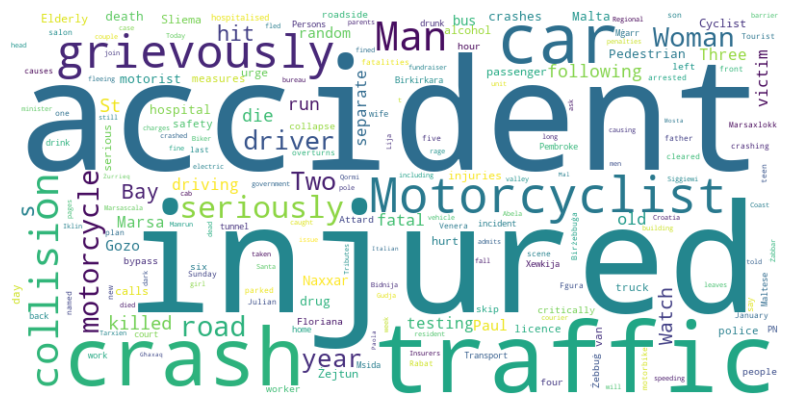

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
traffic_data = pd.read_excel('cleaned_data_using_content.xlsx')
#selecting just records assosciated to accidents
accident_data = traffic_data[traffic_data['accident_flag'] == 1]

## Reading in the cleaned .csv

In [11]:
first_article = min(accident_data['published_date'])
last_article = max(accident_data['published_date'])

In [12]:
print("The oldest article was published on the  ", first_article, "  and the newest article was published on the  ", last_article)

The oldest article was published on the   2024-12-07 00:00:00   and the newest article was published on the   2025-10-14 00:00:00


In [13]:
#adding in the month that the traffic accident took place
accident_data['month'] = pd.DatetimeIndex(accident_data['date of incident']).month

/var/folders/0x/640dcwld7gb2lqvk47n27b4h0000gn/T/ipykernel_3700/457572768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_data['month'] = pd.DatetimeIndex(accident_data['date of incident']).month


In [14]:
#creating a subset to work with for the KMeans
accident_df = accident_data[['source','date of incident','time of incident','weekday of incident','city','latitude','longitude',
                             'month','weather_category','accident_flag','hospital_flag','injury_flag','fatal_flag','severe_flag','minor_flag']].copy()
accident_df.rename(columns={'source':'source','date of incident': 'date','time of incident':'time', 'weekday of incident': 'weekday',
                           'city': 'city','latitude':'latitude','longitude':'longitude','month':'month','weather_category':'weather','accident_flag':'accident','hospital_flag':'hospital',
                            'injury_flag':'injury','fatal_flag':'fatal','severe_flag':'severe',
                           'minor_flag':'minor'}, inplace=True)

In [15]:
#cleaning up
filtered_df = accident_df[accident_df['city'].notnull()]
filtered_df = filtered_df[accident_df['weekday'].notnull()]
#filling na time with mean
filtered_df['time'].fillna((filtered_df['time'].mean()), inplace=True)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 426
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source     289 non-null    object        
 1   date       289 non-null    datetime64[ns]
 2   time       289 non-null    float64       
 3   weekday    289 non-null    object        
 4   city       289 non-null    object        
 5   latitude   289 non-null    float64       
 6   longitude  289 non-null    float64       
 7   month      289 non-null    float64       
 8   weather    289 non-null    object        
 9   accident   289 non-null    int64         
 10  hospital   289 non-null    int64         
 11  injury     289 non-null    int64         
 12  fatal      289 non-null    int64         
 13  severe     289 non-null    int64         
 14  minor      289 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(4)
memory usage: 36.1+ KB


/var/folders/0x/640dcwld7gb2lqvk47n27b4h0000gn/T/ipykernel_3700/3360211176.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[accident_df['weekday'].notnull()]
/var/folders/0x/640dcwld7gb2lqvk47n27b4h0000gn/T/ipykernel_3700/3360211176.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['time'].fillna((filtered_df['time'].mean()), inplace=True)


In [16]:
#creating an arbitrary period where we have the city and the month
#making them to string since this is the only way this will work
filtered_df["period"] = filtered_df["city"].astype(str) + filtered_df["month"].astype(str)

## Adding tags to the data for easier EDA

In [17]:
#mapping categorical variables
#weekday
filtered_df['weekday'] = filtered_df['weekday'].map({'Monday': 1,'Tuesday': 2,'Wednesday': 3,
                                                     'Thursday': 4,'Friday': 5,'Saturday': 6,
                                                     'Sunday': 7})
#weather category
filtered_df['weather'] = filtered_df['weather'].map({'cloudy': 1,'sunny/clear': 2,'rain/drizzle': 3})
#cities to regions
#Southern Harbour District = 1, Northern Harbour District = 2, South Eastern District = 3, Western Dustrict = 4, Northern District = 5, Gozo & COmino District = 6
filtered_df['regions'] = filtered_df['city'].map({'Naxxar': 5,'Marsa': 1,'Saint Paul’s Bay': 5,'Birkirkara': 2,
	'Żebbuġ': 4,'Sliema': 2,'Żejtun': 3,'Attard': 4, 'Paola': 1,'Żabbar': 1,'Floriana': 1,'San Ġwann': 2,'Mellieħa': 5,
	'Rabat': 4,'Fgura': 1,'Imsida': 2,'Santa Venera': 2,'Luqa': 1,'Siġġiewi': 4,'Gżira': 2,'Valletta': 1,'Marsaskala': 3,
	'Pembroke': 2,'Victoria': 6,'Gudja': 3,'Qormi': 2,'Lija': 4,'Xewkija': 6,'Birżebbuġa': 3,'Mosta': 5,'Mġarr': 5,
	'Ħamrun': 2,'Żurrieq': 3,'Pietà': 2,'Għajnsielem': 6,'Tarxien': 1,'Marsaxlokk': 3,'Għaxaq': 3,'Imtarfa': 4,'Iklin': 4,
	'Qala': 6,'Xagħra': 6,'Swieqi': 2,'Kirkop': 3,'Buġibba': 5,'Senglea': 1,'Sannat': 6,'Cospicua': 1,'Balzan': 4,'Ta’ Xbiex': 2,
	'Għarb': 6,'Vittoriosa': 6,'Nadur': 6,'Qrendi': 3,'Imqabba': 3})

In [18]:
day = Counter(filtered_df['weekday'])
day

Counter({4: 52, 3: 50, 7: 44, 5: 40, 1: 36, 2: 34, 6: 33})

In [19]:
w_cat = Counter(filtered_df['weather'])
w_cat

Counter({1: 100, 2: 96, 3: 93})

In [20]:
cities = Counter(filtered_df['city'])
cities

Counter({'Naxxar': 20,
         'Marsa': 18,
         'Saint Paul’s Bay': 14,
         'Birkirkara': 12,
         'Żebbuġ': 11,
         'Sliema': 11,
         'Żejtun': 10,
         'Attard': 10,
         'Paola': 9,
         'Żabbar': 8,
         'Floriana': 8,
         'San Ġwann': 8,
         'Mellieħa': 8,
         'Rabat': 7,
         'Fgura': 7,
         'Imsida': 7,
         'Santa Venera': 7,
         'Luqa': 6,
         'Siġġiewi': 6,
         'Gżira': 6,
         'Valletta': 6,
         'Marsaskala': 5,
         'Pembroke': 5,
         'Victoria': 5,
         'Gudja': 4,
         'Qormi': 4,
         'Lija': 4,
         'Xewkija': 4,
         'Birżebbuġa': 4,
         'Mosta': 4,
         'Mġarr': 4,
         'Ħamrun': 4,
         'Żurrieq': 3,
         'Pietà': 3,
         'Għajnsielem': 3,
         'Tarxien': 3,
         'Marsaxlokk': 3,
         'Għaxaq': 2,
         'Imtarfa': 2,
         'Iklin': 2,
         'Qala': 2,
         'Xagħra': 2,
         'Swieqi': 2,
       

In [21]:
regions = Counter(filtered_df['regions'])
regions

Counter({2: 70, 1: 68, 5: 52, 4: 43, 3: 35, 6: 21})

In [22]:
months = Counter(filtered_df['month'])
months

Counter({8.0: 50,
         7.0: 38,
         2.0: 28,
         9.0: 27,
         12.0: 26,
         4.0: 25,
         6.0: 24,
         1.0: 23,
         5.0: 22,
         10.0: 14,
         3.0: 12})

In [23]:
time = Counter(filtered_df['time'])
time

Counter({1303.219512195122: 43,
         2100.0: 10,
         1330.0: 9,
         800.0: 8,
         1800.0: 8,
         1015.0: 8,
         1530.0: 8,
         530.0: 8,
         930.0: 7,
         1830.0: 7,
         1315.0: 7,
         1100.0: 7,
         1700.0: 7,
         745.0: 6,
         900.0: 6,
         1130.0: 6,
         1300.0: 5,
         2200.0: 5,
         730.0: 5,
         1930.0: 5,
         1415.0: 5,
         1000.0: 4,
         1430.0: 4,
         1745.0: 4,
         1600.0: 4,
         1230.0: 4,
         2045.0: 3,
         1030.0: 3,
         830.0: 3,
         1515.0: 3,
         2300.0: 3,
         945.0: 3,
         100.0: 3,
         1900.0: 3,
         1200.0: 3,
         630.0: 3,
         2000.0: 3,
         1730.0: 3,
         850.0: 2,
         815.0: 2,
         915.0: 2,
         1945.0: 2,
         2330.0: 2,
         2115.0: 2,
         500.0: 2,
         1215.0: 2,
         200.0: 2,
         715.0: 2,
         430.0: 2,
         1815.0: 2,
    

In [24]:
source = Counter(filtered_df['source'])
source

Counter({'news_article': 182, 'police_report': 107})